# Simple CRAG - Corrective Retrieval Augmented Generation

Inspiration: https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag.ipynb

In [1]:
%pip install -qq -U beautifulsoup4 langchain-chroma langchain-core

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

True

## Setup / Grabbing Documents

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://ai-office-hours.beehiiv.com/p/beyond-benchmarks",
    "https://ai-office-hours.beehiiv.com/p/evaluating-ai-agent-tool-selection",
    "https://ai-office-hours.beehiiv.com/p/re-ranking-rag",
    "https://ai-office-hours.beehiiv.com/p/quantizing-llms-llama-3",
    "https://ai-office-hours.beehiiv.com/p/llm-probing"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
    persist_directory='./db'
    
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
question = "Tell me about benchmarks"
docs = retriever.invoke(question)
for doc in docs:
    print(doc.page_content[:50], '...', doc.metadata['source'])

top-line conversation starter when evaluating an L ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
(like testing a model’s financial tool selecting a ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
Beyond BenchmarksAI Office HoursLoginSubscribe0AI  ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
fine-tuning process. Test sets in general (benchma ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks


## Retrieval Grader

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with structured output
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)


# Prompt
system = """Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader  # llm + prompt

for doc in docs:
    doc_txt = doc.page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}), doc_txt[:50], '...', doc.metadata['source'])

binary_score='yes' top-line conversation starter when evaluating an L ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
binary_score='yes' (like testing a model’s financial tool selecting a ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
binary_score='yes' Beyond BenchmarksAI Office HoursLoginSubscribe0AI  ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
binary_score='yes' fine-tuning process. Test sets in general (benchma ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks


## Generate Compoments

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt - Standard RAG prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."),
    ("human", "Question: {question}\n\nContext: {context}")
])

# Display the prompt structure
for message in prompt.messages:
    print(type(message))
    print(message.prompt.template)
    print('-----')

<class 'langchain_core.prompts.chat.SystemMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
-----
<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
Question: {question}

Context: {context}
-----


In [7]:
# LLM
llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Benchmarks are standardized open-source test sets used to evaluate AI models on specific tasks, providing a fair comparison by using agreed-upon train/validation/test splits. They serve as a useful starting point to shortlist models but have limitations, such as models gaming the system by exploiting biases or shortcuts in the data, and data contamination where training data overlaps with benchmark data. High benchmark scores do not necessarily indicate true generalization or human-level understanding, so benchmarks should be a conversation starter, not the final measure of a model's capability.


## Question Re-writer / The Corrective Part

In [8]:
# A different LLM, just to show we can use multiple LLMs in our calls
bigger_llm = ChatOpenAI(model="gpt-4.1", temperature=0.1)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | bigger_llm | StrOutputParser()
question, question_rewriter.invoke({"question": question})

('Tell me about benchmarks',
 'What are benchmarks and how are they used to measure performance in different fields?')

## Graph State

In [9]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        times_transformed: number of times the question has been re-written
        web_search: if we should be doing a web search (not implemented in this notebook)
    """

    question: str
    generation: str
    documents: List[str]
    times_transformed: int
    web_search: str

## The Nodes

In [10]:

def set_state(state):
    """
    Sets initial state

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---SET STATE---")

    return {"times_transformed": 0}



def retrieve(state):
    print(state)
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": format_docs(documents), "question": question})
    return {"generation": generation}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    times_transformed = state["times_transformed"]
    times_transformed += 1

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print('---NEW QUESTION---')
    print(better_question)
    return {"question": better_question, "times_transformed": times_transformed}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        print(d.metadata['source'], f'Grade: {grade}')
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
    if len(filtered_docs) == 0:
        print("---GRADE: DOCUMENTS NOT RELEVANT---")
        web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}


## The Edges

In [11]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    # state["documents"]

    if web_search == "Yes":
        # check times_transformed
        if state["times_transformed"] >= 3:
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION AND WE HAVE TRANSFORMED 3 TIMES, GENERATE---"
            )
            return "should_generate"

        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "should_transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "should_generate"

## Building the Graph

In [12]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("set_state", set_state)  # set_state
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "set_state")
workflow.add_edge("set_state", "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "should_transform_query": "transform_query",
        "should_generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

## Running the Graph

In [13]:
# Run
inputs = {"question": "What on earth is few shot learning?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

---SET STATE---
Node 'set_state':
{'question': 'What on earth is few shot learning?', 'times_transformed': 0}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':
---GENERATE---
Node 'generate':
Few-shot learning is a method where the model is given a set of high-quality examples, each with input and desired output, for a target task. This helps the model better understand human intentions and criteria, often leading to improved performance compared to zero-shot 

In [14]:
# Run
inputs = {"question": "How to make good inputs to AI?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

---SET STATE---
Node 'set_state':
{'question': 'How to make good inputs to AI?', 'times_transformed': 0}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':
---GENERATE---
Node 'generate':
To make good inputs to AI, provide clear, specific, and well-structured information or questions. This helps the AI understand your request accurately and deliver relevant results. In my process, I first interpret your input, plan the tasks needed, select the appropriate model, and then execute the task to generate precise predictions or answers.


In [15]:
# Run
inputs = {"question": "How big is the moon?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

---SET STATE---
Node 'set_state':
{'question': 'How big is the moon?', 'times_transformed': 0}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: no
---GRADE: DOCUMENTS NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---TRANSFORM QUERY---
---NEW QUESTION---
What is the diameter and surface area of the Moon?
Node 'transform_query':
{'question': 'What is the diameter and surface area of the Moon?', 'documents': [], 'times_transformed': 1, 'web_search': 'Yes'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://lilianweng.github.io/posts/2023-

## Visualize the Graph

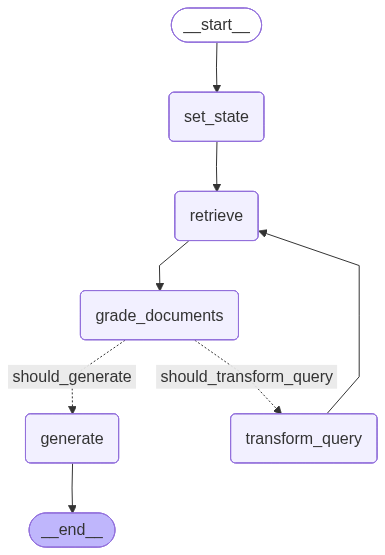

In [16]:
# Visualize our graph
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass